In [76]:
%load_ext autoreload
%autoreload 2

%pylab inline
import sys, fiona
sys.path.append("../")
sys.path.insert(0,"/home/luca/Code/topojson.git/")
import mappy as mpy
import geopandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['e', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# interesting link for checking overlaps
https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

In [120]:
infile = "output-map-data.gpkg"
layer_name  = "polygons_labelled"
column_name="unit_name"

infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01.gpkg"
layer_name= "subregion_fixed"
column_name="Unit_Code"

In [121]:
import geopandas as gpd

In [122]:
fiona.listlayers(infile)

['subregion_fixed']

In [123]:
polygons = gpd.read_file(infile, layer=layer_name)
polygons = mpy.explode_multipolygons(polygons)
polygons = mpy.remove_null_geometries(polygons) 
polygons =  mpy.remove_truly_duplicated_geometries(polygons)

<AxesSubplot:>

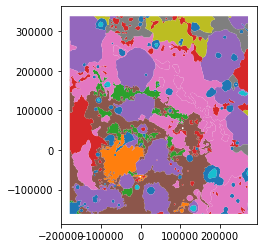

In [124]:
polygons.plot(column=column_name)

In [125]:
polygons.to_file("dissolved.gpkg", layer="dissolved", driver="GPKG")

In [126]:
aspd = mpy.generate_label_points(polygons)

In [127]:
aspd = mpy.transfer_polygons_fields_to_points(aspd, polygons)

../mappy/geom_ops.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown", ...

  return geopandas.sjoin(points, polygons)


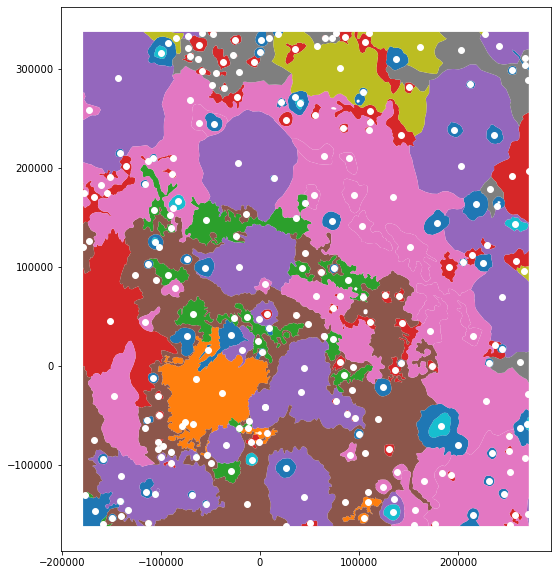

In [128]:
figure(figsize=(10,10))
polygons.plot(column=column_name,ax=gca())
aspd.plot(ax=gca(), color="white", markersize=35)
aspd.to_file("test.gpkg", driver="GPKG", layer="points")

In [129]:
mpy.check_validity_of_geometries(polygons)

In [130]:
import topojson 

tj = topojson.Topology(polygons, shared_coords=False)
# tj = tj.toposimplify(1).topoquantize(1e6)

In [131]:
topojson.Topology?

Init signature:
topojson.Topology(
    data,
    topology=True,
    prequantize=True,
    topoquantize=False,
    presimplify=False,
    toposimplify=False,
    shared_coords=True,
    prevent_oversimplify=True,
    simplify_with='shapely',
    simplify_algorithm='dp',
    winding_order='CW_CCW',
)
Docstring:     
Returns a TopoJSON topology for the specified geometric object. TopoJSON is an 
extension of GeoJSON providing multiple approaches to compress the geographical 
input data. These options include simplifying the linestrings or quantizing the 
coordinates but foremost the computation of a topology.

Parameters
----------
data : _any_ geometric type
    Geometric data that should be converted into TopoJSON 
topology : boolean
    Specifiy if the topology should be computed for deriving the TopoJSON. 
    Default is `True`.
prequantize : boolean, int
    If the prequantization parameter is specified, the input geometry is 
    quantized prior to computing the topology, the return

In [132]:
len(tj.output["arcs"])

1195

In [133]:
asgdf =  tj.to_gdf()

In [134]:
asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

In [135]:

# arc_ids = tj.output["objects"]["data"]["geometries"][4]["arcs"][0]


# for id in arc_ids:
#     if id < 0:
#         id = -id-1
#     pts = tj.output["arcs"][np.abs(id)]
#     pts = np.cumsum(np.array(pts), axis=0)
#     plot(*pts.T)

In [136]:
# tj.to_gdf().plot(column=column_name)

In [137]:
import topojson, copy
from topojson.ops import np_array_from_arcs


def extract_numpy_arcs(topology):
    s = np.array(topology.output["transform"]["scale"])
    t = np.array(topology.output["transform"]["translate"])
    top = topology._resolve_coords(topology.output)
    np_arcs = np_array_from_arcs(top["arcs"])
    out = topojson.ops.dequantize(np_arcs, s, t)

    out = [o[~np.isnan(o).any(axis=1)] for o in out]
    
    return out

out = extract_numpy_arcs(tj)

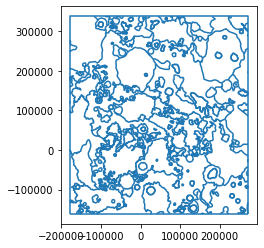

In [138]:
import shapely
from shapely.geometry import asLineString
glines = [asLineString(e) for e in out]
asg = geopandas.GeoDataFrame(geometry=glines)
asg.plot()
show()

asg.to_file("lines.gpkg", layer="lines", driver="GPKG")

In [274]:
import attr
@attr.attrs(eq=False)
class Arc:
    points = attr.ib(repr=False)
    real_points = attr.ib(repr=False)
    id = attr.ib()
    separating_polygons = attr.ib(factory=list, repr=False)
    
    def plot(self, *attrs, **kwattrs):
        plot(*np.cumsum(self.points, axis=0).T, *attrs, **kwattrs)
        
    def plot_real(self, *attrs, **kwattrs):
        plot(*self.real_points.T, *attrs, **kwattrs)
    
@attr.attrs(eq=False)
class Polygon:
    arcs = attr.ib(factory=list, repr=True) 
    
    def has_holes(self):
        if len(self.arcs) > 1:
            return True
        else:
            return False


In [275]:
arcs = [Arc(points=np.array(arc_pts),real_points=real, id=id) for id, (arc_pts, real) in enumerate(zip(tj.output["arcs"], out))]


In [276]:
def retrive_arcs_as_objects(ids, objectslist):
    ids = np.array(ids)
    reverse = ids < 0
    
    ids[reverse] = -ids[reverse]-1
    arcs = np.array(objectslist)[ids]
    polarity = reverse
    
    return np.column_stack([arcs,polarity])

def retrieve_polygon(pol):
    out=[]
    for arclist in pol["arcs"]:
        out.append(retrive_arcs_as_objects(arclist, arcs))
    
    p = Polygon(out)
    for l in out:
        for arc, order in l:
            if p not in arc.separating_polygons:
                arc.separating_polygons.append(p)
    return  p
    
def retrieve_all_polygons(geometries):
    return [retrieve_polygon(g) for g in geometries]
    

polygons = retrieve_all_polygons(tj.output["objects"]["data"]["geometries"])

In [284]:
arcs[30].separating_polygons

[Polygon(arcs=[array([[Arc(id=1191), True],
        [Arc(id=29), False],
        [Arc(id=1059), True],
        [Arc(id=205), True],
        [Arc(id=30), False],
        [Arc(id=1192), True]], dtype=object)])]

In [150]:
def topology_to_pol_objects(tj):

    pols = []
    # all_arcs = []
    for pol in tj.output["objects"]["data"]["geometries"]:
        
        for li in pol["arcs"][0]:
            olist = []
            oris = []
            for arc in li:
                if arc < 0:
                    arc = -arc-1
                    oris.append(False)
                else:
                    oris.append(True)
                myarc = arcs[arc]
                olist.append(myarc)
            newarcs.append(olist)
            
            
        holes_arcs = []
        if len(pol["arcs"]) > 1:
            for li in pol["arcs"][1]:
                olist = []
                oris = []
                for arc in li:
                    if arc < 0:
                        arc = -arc-1
                        oris.append(False)
                    else:
                        oris.append(True)
                    myarc = arcs[arc]
                    olist.append(myarc)
                holes_arcs.append(olist)
            

        mypol = Polygon(newarcs, orientations=oris)
        pols.append(mypol)

        for ll in newarcs:
            for narc in ll:
                if mypol not in narc.separating_polygons:
                    narc.separating_polygons.append(mypol)

#     triple = []
#     # just checks            
#     for pol in pols:
#         for l in pol.arcs:
#             for arc in l:
#                 if len(arc.separating_polygons) > 2:
#                     print(f"more than 2 pols: {len(arc.separating_polygons)}")
#                     triple.append(arc)
#                 if len(arc.separating_polygons) == 1:
                    pass
                
    return pols

In [157]:
pols = topology_to_pol_objects(tj)
# pols

In [152]:
single = []
newarcs = []
for a in arcs:
    if len(a.separating_polygons) == 1:
        single.append(a)
    else:
        newarcs.append(a)
        

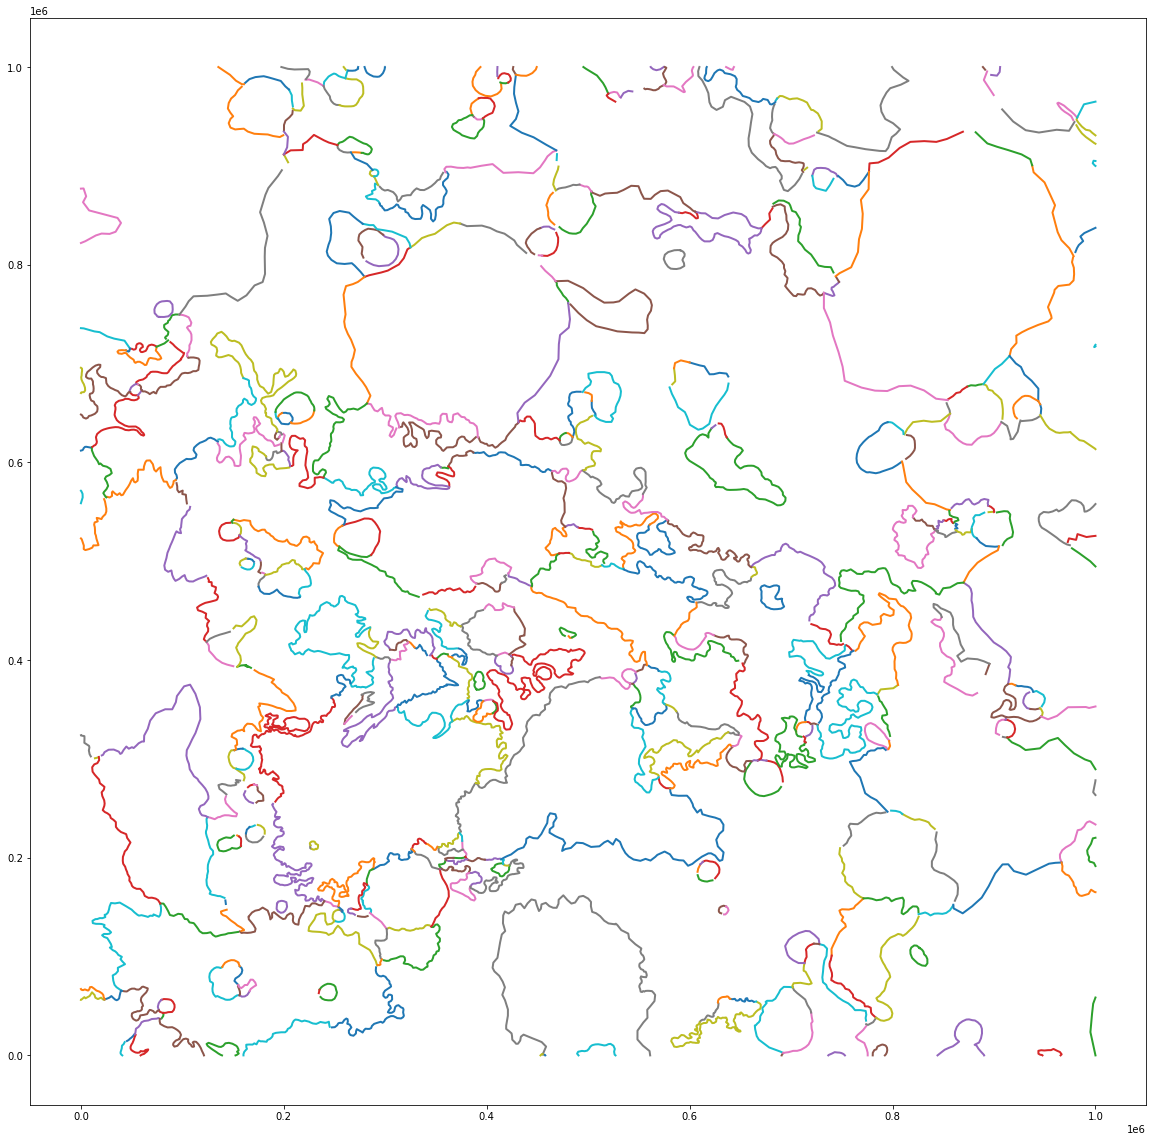

In [153]:
figure(figsize=(20,20))
for a in newarcs:
    a.plot(linewidth=2)

In [156]:
a.separating_polygons

[Polygon(arcs=[[Arc(id=1186), Arc(id=1187), Arc(id=1188), Arc(id=1189), Arc(id=1190), Arc(id=1191), Arc(id=1192), Arc(id=1193), Arc(id=1194)]], orientations=[True, True, True, True, True, True, True, True, True])]

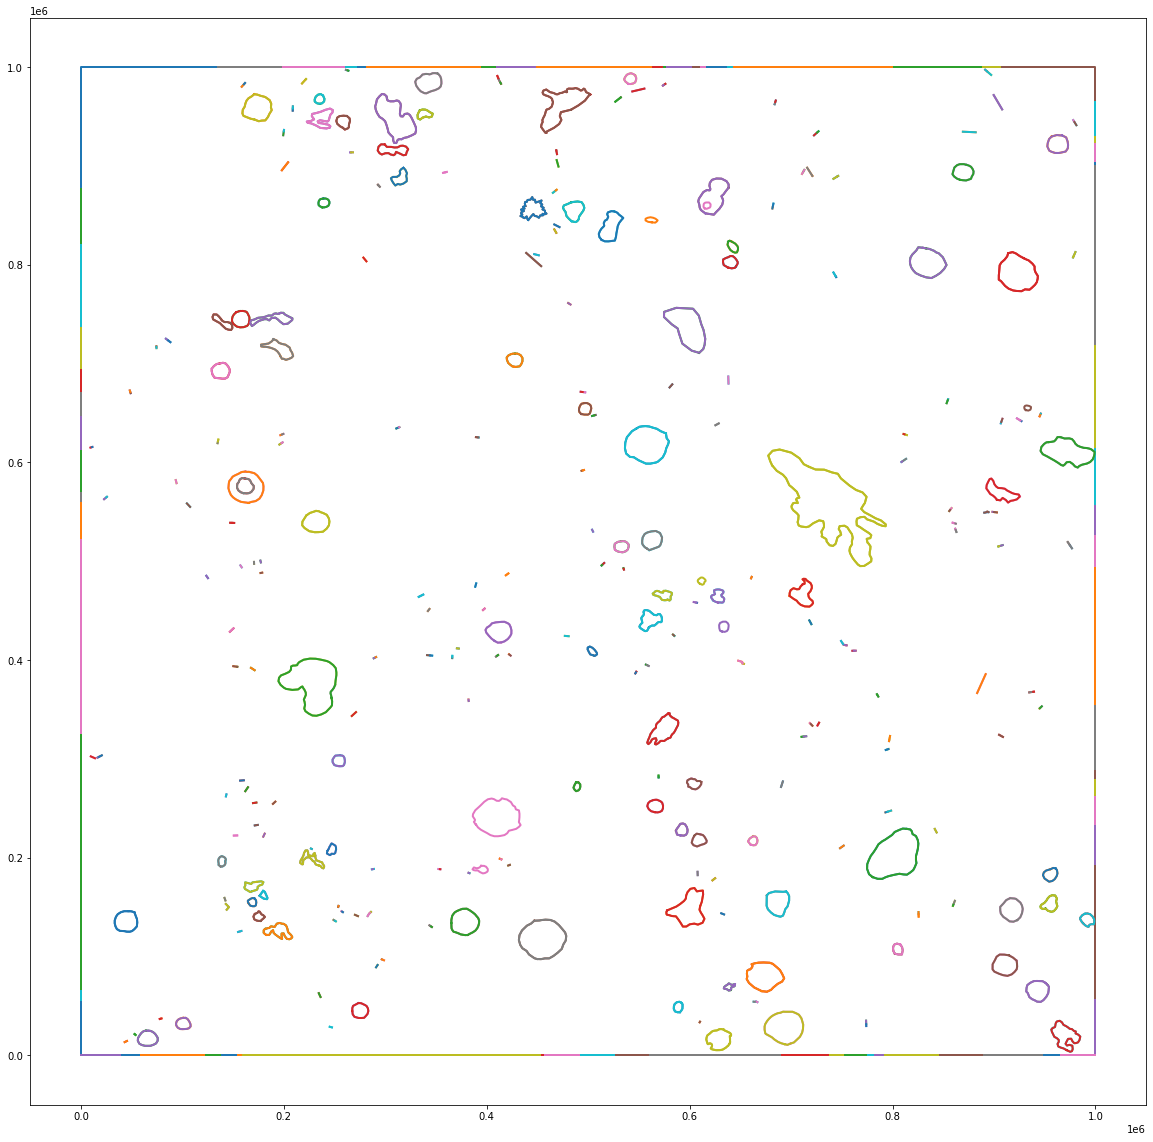

In [154]:
figure(figsize=(20,20))
for a in single:
    a.plot(linewidth=2)

In [24]:
asgdf = tj.to_gdf()
geoms = asgdf.geometry
simple = gpd.GeoDataFrame(geometry=geoms)

In [25]:
asgdf.columns

Index(['geometry', 'unit_name'], dtype='object')

In [26]:
if "Id" in asgdf.columns:
    asgdf = asgdf.drop(columns="Id")
asgdf.to_file("test.gpkg",layer="test", driver="GPKG") # for some reason Id column breaks fiona

(-126.833014562758, 4483.832784916166, -3452.1244527784684, 25.842347143428242)

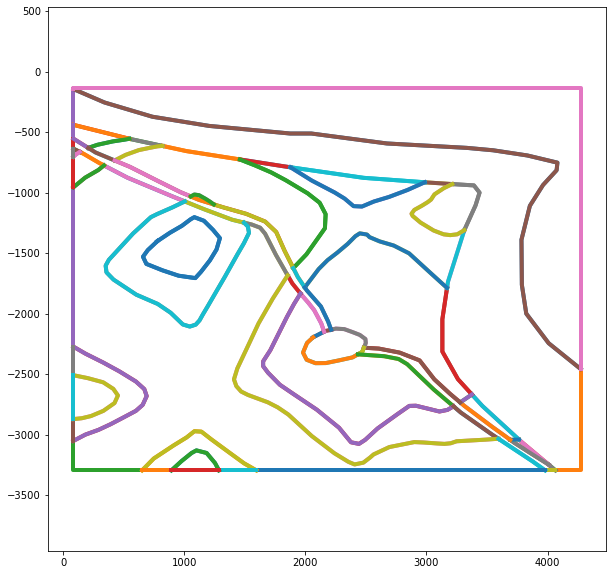

In [27]:
figure(figsize=(10,10))

s = np.array(tj.output["transform"]["scale"])
t = np.array(tj.output["transform"]["translate"])

for id, pol in enumerate(pols):
# pol = pols[6]
#     figure()
    for l in pol.arcs:

        for arc in l:
            aa = np.cumsum(arc.points, axis=0) * s + t
            plot(*aa.T, linewidth=4)
#             text(*aa[0], str(arc.id))

axis('equal')

In [28]:
# tt = list(id_to_arcs.values())[0]
# for idpol, pol in enumerate(tt.separating_polygons):
#     for l in pol.arcs:
#         for arc in l:
#             aa = arc.points
#             plot(*np.cumsum(aa, axis=0).T)
#             text(*aa[0], str(idpol))

In [29]:
# tt = triple[1]
# for idpol, pol in enumerate(tt.separating_polygons):
#     for l in pol.arcs:
#         for arc in l:
#             aa = arc.points
#             plot(*np.cumsum(aa, axis=0).T)
#             text(*aa[0], str(idpol))

In [30]:
@attr.attrs(frozen=True)
class Node():
    x = attr.ib()
    y = attr.ib()
    
    def as_np(self):
        return np.array([self.x,self.y])
# hash(Node(1,2))

In [31]:
hash(Node(1,2))

8314821564096775808

In [32]:
import networkx
g = networkx.Graph()
nodes = []

for arc in arcs:
    start = Node(*np.cumsum(arc.points, axis=0)[0])
    end = Node(*np.cumsum(arc.points, axis=0)[-1])
    
#     if start == end:
#         print("equals")
#         print(f"arc {np.cumsum(arc.points, axis=0)}")
        
    g.add_edge(start, end, arc=arc)
    
    
    

In [33]:
# networkx.get_edge_attributes(g, "arc")

In [34]:
pos= {}
for node in g.nodes:
    mypos = [node.x, node.y] 
    pos[node] = mypos
    
# pos

In [35]:
# a = np.array([12,3])
# networkx.draw?

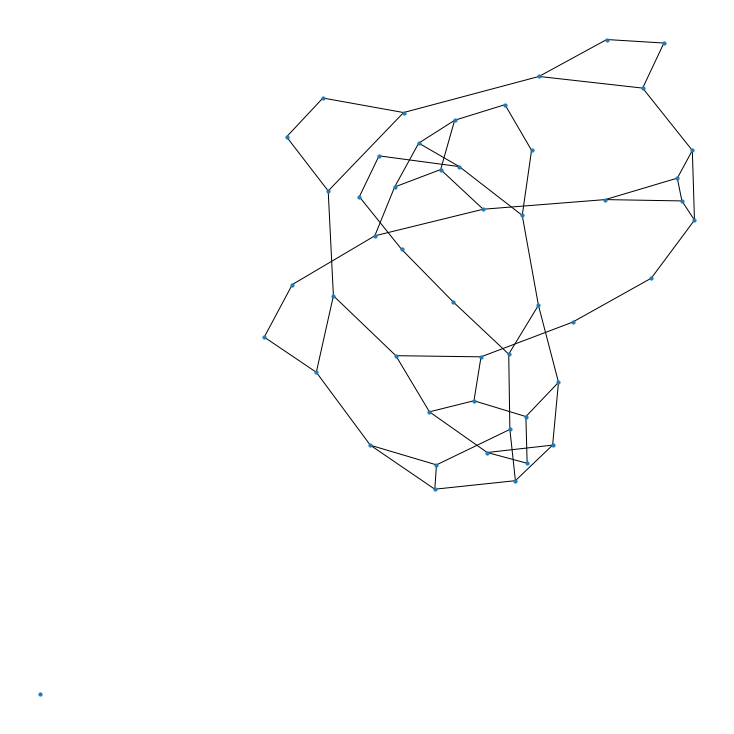

In [36]:
figure(figsize=(10,10))
networkx.draw(g, node_size=10)

In [37]:
# c = np.array([0,0])

# p1 = np.array([0,1])
# p2 = np.array([1,0])
# p3 = np.array([0,-1])

# azimuth(c, p1) - azimuth(c , p3)

In [38]:
from itertools import combinations

attrs = networkx.get_edge_attributes(g, "arc")

def get_edge_point(edge, g, center_node):
    arc1 = g.get_edge_data(*edge)["arc"]
    arc_1_pts = np.cumsum(arc1.points, axis=0)
    
    if np.array_equal(arc_1_pts[0] ,center_node.as_np()):
        arc1_pt = arc_1_pts[1]
    elif np.array_equal(arc_1_pts[-1] ,center_node.as_np()):
        arc1_pt = arc_1_pts[-2]
    else:
        print("no point in common")
        
    return arc1_pt


def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def select_best_couple(edges, g, node):
    angles = []
    possible_edges = []
    for edge1, edge2 in combinations(edges,r=2):
        arc1_pt = get_edge_point(edge1, g, node)
        arc2_pt = get_edge_point(edge2, g, node)
        
        angle = azimuth(arc1_pt, node.as_np()) - azimuth(arc2_pt, node.as_np())
        angle = np.abs(angle)
        if angle> 180:
            angle = 360-angle
        angle = 180-angle
#         print(angle)
        angles.append(angle)
        possible_edges.append([edge1, edge2])
        
    minangleid = np.argmin(angles)
    selected_angle = angles[minangleid]
    selected_edges =  possible_edges[minangleid]
    return selected_edges
    
couples = []
for node in g.nodes:
    edges = list(g.edges(nbunch=node))
    if len(edges) > 3:
        print(f"larger than 3: {len(edges)}")
    if len(edges) == 1:
        print("1 edge, nothing to do")
        continue
    
    while len(edges) > 1:
        ed1, ed2 = select_best_couple(edges, g, node)
        couples.append([ed1, ed2])
        edges.remove(ed1)
        edges.remove(ed2)
    
        
   
    
        
        
     
        
        
    

1 edge, nothing to do


In [39]:
id_to_edge = {}
edge_to_id = {}
for i, edge in enumerate(g.edges):
    id_to_edge[i] = edge
    edge_to_id[edge] = i

In [40]:
# test = couple[1]
# test

In [41]:
test2 = list(edge_to_id.keys())[3]
test2

(Node(x=9501, y=0), Node(x=9297, y=0))

In [42]:
test in edge_to_id.keys()

False

In [43]:
edge_to_id.keys()

dict_keys([(Node(x=9999, y=2647), Node(x=9501, y=0)), (Node(x=9999, y=2647), Node(x=0, y=9962)), (Node(x=9501, y=0), Node(x=9367, y=150)), (Node(x=9501, y=0), Node(x=9297, y=0)), (Node(x=0, y=9028), Node(x=0, y=9962)), (Node(x=0, y=9028), Node(x=1103, y=8664)), (Node(x=0, y=9028), Node(x=0, y=8666)), (Node(x=9367, y=150), Node(x=8781, y=805)), (Node(x=9367, y=150), Node(x=8612, y=796)), (Node(x=9297, y=0), Node(x=8377, y=825)), (Node(x=9297, y=0), Node(x=3604, y=0)), (Node(x=8781, y=805), Node(x=7854, y=1982)), (Node(x=8781, y=805), Node(x=8612, y=796)), (Node(x=8612, y=796), Node(x=7624, y=1775)), (Node(x=7854, y=1982), Node(x=7364, y=4767)), (Node(x=7854, y=1982), Node(x=7624, y=1775)), (Node(x=7624, y=1775), Node(x=5725, y=3204)), (Node(x=7364, y=4767), Node(x=7705, y=6276)), (Node(x=7364, y=4767), Node(x=4560, y=4780)), (Node(x=5725, y=3204), Node(x=5079, y=3674)), (Node(x=5725, y=3204), Node(x=5608, y=3031)), (Node(x=7705, y=6276), Node(x=7467, y=7480)), (Node(x=4560, y=4780), Nod

In [44]:
def invert_edge(aa):
    return (aa[1], aa[0])

In [45]:
ge = networkx.Graph()
for couple in couples:
#     print("done")
    try:
        id1 = edge_to_id[couple[0]]
    except:
        id1 = edge_to_id[invert_edge(couple[0])]
#         print(f"seems edge {couple[0]} not in dict")
    
    try:
        id2 = edge_to_id[couple[1]]
    except:
        id2 = edge_to_id[invert_edge(couple[1])]
    
    
    ge.add_edge(id1, id2)

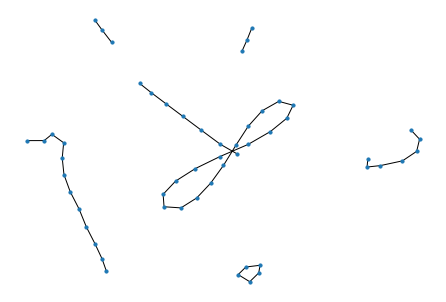

In [46]:
networkx.draw(ge, node_size=10)

In [47]:
edges = []
ccs = list(networkx.connected_components(ge))


for cc in ccs:
    edge_set = []
    for eid in cc:
        edge = id_to_edge[eid]
        edge_set.append(edge)
    edges.append(edge_set)

In [48]:
data = [["B", "A"], ["C", "B"], ["D", "C"], ["E", "D"]]
data

def domino_sort(data):
    ordered = []
    prev = data[0]

    if prev[1] not in data[1]:
        prev = [prev[1], prev[0]]

    ordered.append(prev)

    for i, item in enumerate(data[1:]):
        if item[0] != prev[1]:
            item = [item[1], item[0]]

        ordered.append(item)
        prev = item
    return ordered
ordered = domino_sort(data)

In [49]:
domino_sort(edges[0])

[[Node(x=9501, y=0), Node(x=9999, y=2647)],
 (Node(x=9999, y=2647), Node(x=0, y=9962)),
 [Node(x=1932, y=0), Node(x=2868, y=0)],
 [Node(x=9297, y=0), Node(x=9501, y=0)],
 [Node(x=0, y=9962), Node(x=0, y=9028)],
 [Node(x=0, y=8405), Node(x=0, y=8666)],
 [Node(x=0, y=8666), Node(x=0, y=9028)],
 [Node(x=0, y=2485), Node(x=0, y=1339)],
 [Node(x=3604, y=0), Node(x=9297, y=0)],
 [Node(x=0, y=8197), Node(x=0, y=8405)],
 [Node(x=2868, y=0), Node(x=3604, y=0)],
 [Node(x=0, y=770), Node(x=1354, y=0)],
 (Node(x=1354, y=0), Node(x=1932, y=0)),
 [Node(x=0, y=1339), Node(x=0, y=770)],
 [Node(x=0, y=7397), Node(x=0, y=3231)],
 (Node(x=0, y=3231), Node(x=0, y=2485)),
 [Node(x=0, y=8197), Node(x=0, y=7397)]]

[ 0  1  4  6 36 46 60 57 58 65 56 53 54 64 52 10  3]
origi (Node(x=9999, y=2647), Node(x=9501, y=0))
flip
(Node(x=9501, y=0), Node(x=9999, y=2647))
origi (Node(x=9999, y=2647), Node(x=0, y=9962))
flip
(Node(x=0, y=9962), Node(x=9999, y=2647))
origi (Node(x=0, y=9028), Node(x=0, y=9962))
flip
(Node(x=0, y=9962), Node(x=0, y=9028))
origi (Node(x=0, y=9028), Node(x=0, y=8666))
flip
(Node(x=0, y=8666), Node(x=0, y=9028))
origi (Node(x=0, y=8666), Node(x=0, y=8405))
flip
(Node(x=0, y=8405), Node(x=0, y=8666))
origi (Node(x=0, y=8405), Node(x=0, y=8197))
flip
(Node(x=0, y=8197), Node(x=0, y=8405))
origi (Node(x=0, y=7397), Node(x=0, y=8197))
flip
(Node(x=0, y=8197), Node(x=0, y=7397))
origi (Node(x=0, y=3231), Node(x=0, y=7397))
flip
(Node(x=0, y=7397), Node(x=0, y=3231))
origi (Node(x=0, y=3231), Node(x=0, y=2485))
flip
(Node(x=0, y=2485), Node(x=0, y=3231))
origi (Node(x=0, y=1339), Node(x=0, y=2485))
flip
(Node(x=0, y=2485), Node(x=0, y=1339))
origi (Node(x=0, y=770), Node(x=0, y=1339))
f

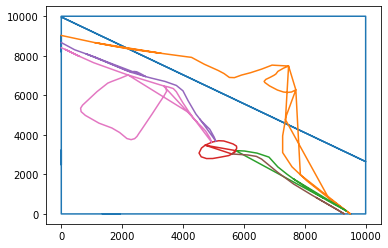

In [50]:
def assembly_line(g, sug, id_to_edge):
    leaves = []
    for node in subg.nodes():
        if subg.degree(node) == 1:
            leaves.append(node)


    if len(leaves) == 0:
        cycle = networkx.algorithms.find_cycle(subg)
        order = np.array(cycle)[:,0]
    else:
        order = np.array(networkx.algorithms.shortest_path(subg, leaves[0], leaves[1]))

    print(order)

    arcs = networkx.get_edge_attributes(g, "arc")

    line = []
    for i, id in enumerate(order):
        myedge = id_to_edge[id]
        try:
            next_id = order[i+1]
        except:
            next_id = None

        toflip = False    
        print(f"origi {myedge}")
        if next_id:
            next_edge = id_to_edge[next_id]

            if myedge[1] != next_edge[0] or myedge[1] != next_edge[1]:
                toflip = True

        else: #last edge
            prev_id = order[i-1]
            prev_edge = id_to_edge[prev_id]
            if myedge[0] != prev_edge[1] or myedge[0] != prev_edge[0]:
                toflip = True


        
        
        arc = arcs[myedge]
        if toflip:
            print("flip")
            myedge = (myedge[1], myedge[0])
            
        print(myedge)
        pts = np.cumsum(arc.points, 0)
        
        if not np.array_equal(myedge[0].as_np(), pts[0]):
            pts = np.flip(pts, axis=0)
            
#         node1, node2 = myedge
#         if toflip:
# #             print("flip")
#             pts = np.flip(pts, axis=0)
#         print(pts)
        

        line.append(pts)

    lines = np.row_stack(line)
    return lines


from shapely.geometry import LineString, LinearRing
for cc in ccs:
    subg = ge.subgraph(cc)
    lines = assembly_line(g, subg, id_to_edge)
    if np.array_equal(lines[0], lines[-1]):
        line =LinearRing(lines)
    else:
        line = LineString(lines)
    
    plot(*lines.T)

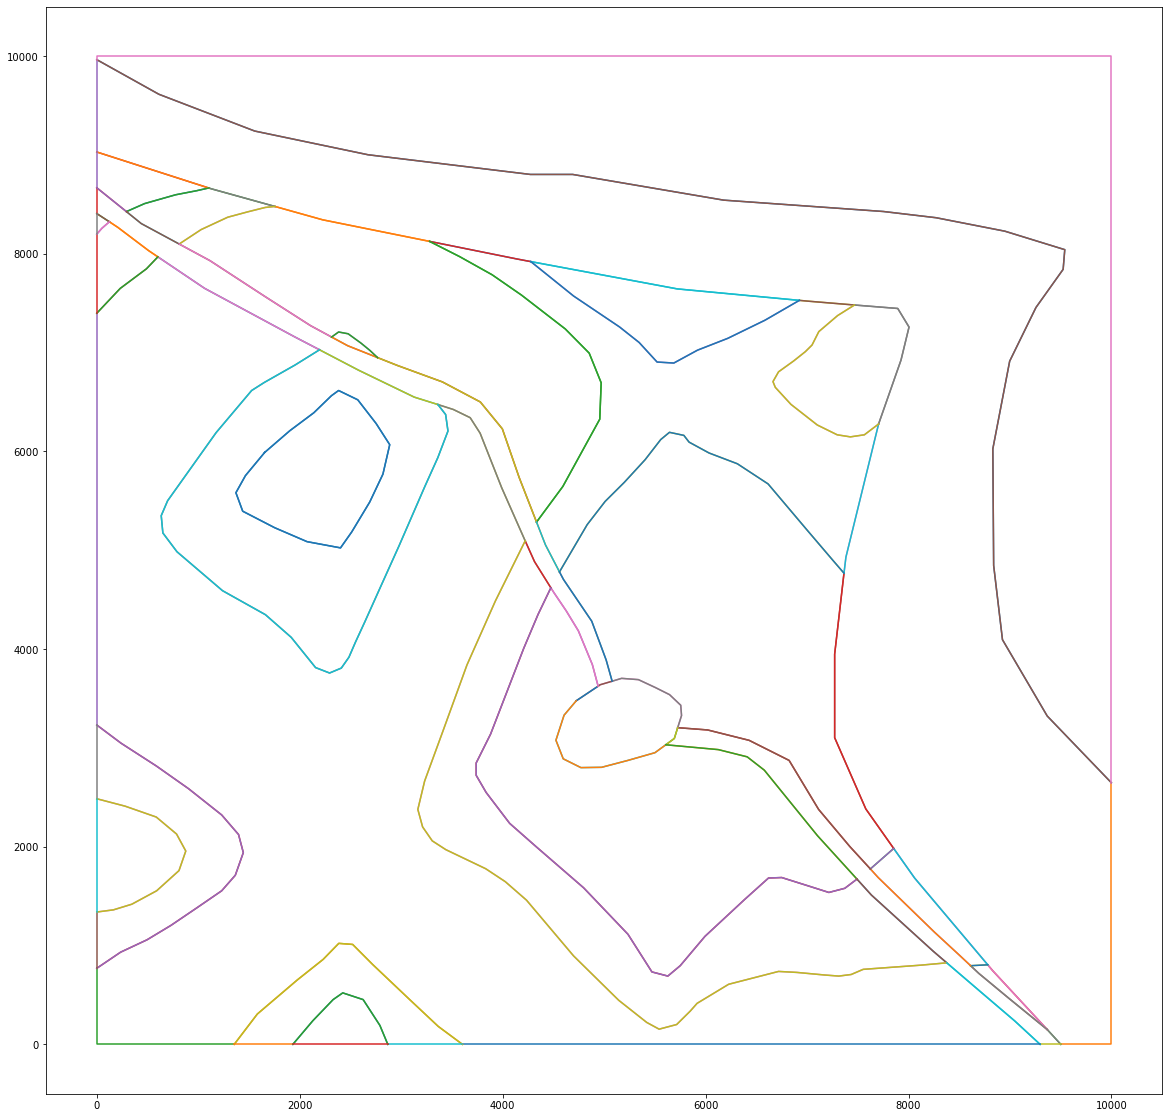

In [51]:
figure(figsize=(20,20))
for pol in pols:
    for l in pol.arcs:
        for i, a in enumerate(l):
    #         print (arc.points)
            pts = np.cumsum(a.points, axis=0)
            if len(a.separating_polygons) > 2:
                text(*pts[0],str(i))
            plot(*pts.T)

In [52]:
arc.separating_polygons

[Polygon(arcs=[[Arc(id=55), Arc(id=56)], [Arc(id=73)]], orientations=[True]),
 Polygon(arcs=[[Arc(id=73)]], orientations=[True])]

In [53]:
@attr.attrs
class Line():
    arcs = attr.ib(factory=list)

for pol in pols:
    myarcs = []
    for l in pol.arcs:
        print("new")
        for arc in l:
            print(arc)
            
        
    

new
Arc(id=2)
Arc(id=0)
Arc(id=4)
Arc(id=6)
Arc(id=8)
Arc(id=11)
Arc(id=14)
Arc(id=18)
Arc(id=17)
Arc(id=20)
Arc(id=16)
Arc(id=22)
Arc(id=24)
Arc(id=26)
Arc(id=1)
new
Arc(id=2)
Arc(id=3)
new
Arc(id=4)
Arc(id=5)
Arc(id=50)
Arc(id=47)
Arc(id=33)
Arc(id=30)
Arc(id=13)
Arc(id=10)
Arc(id=7)
new
Arc(id=6)
Arc(id=7)
Arc(id=9)
new
Arc(id=8)
Arc(id=9)
Arc(id=10)
Arc(id=12)
new
Arc(id=11)
Arc(id=12)
Arc(id=13)
Arc(id=29)
Arc(id=42)
Arc(id=15)
new
Arc(id=14)
Arc(id=15)
Arc(id=41)
Arc(id=23)
Arc(id=16)
Arc(id=21)
Arc(id=17)
Arc(id=19)
new
Arc(id=18)
Arc(id=19)
new
Arc(id=20)
Arc(id=21)
new
Arc(id=22)
Arc(id=23)
Arc(id=40)
Arc(id=44)
Arc(id=39)
Arc(id=25)
new
Arc(id=24)
Arc(id=25)
Arc(id=38)
Arc(id=27)
new
Arc(id=26)
Arc(id=27)
Arc(id=37)
Arc(id=28)
new
Arc(id=31)
Arc(id=34)
Arc(id=29)
Arc(id=30)
Arc(id=32)
new
Arc(id=31)
Arc(id=32)
Arc(id=33)
Arc(id=46)
Arc(id=35)
new
Arc(id=34)
Arc(id=35)
Arc(id=45)
Arc(id=48)
Arc(id=55)
Arc(id=54)
Arc(id=57)
Arc(id=60)
Arc(id=36)
Arc(id=37)
Arc(id=38)
Arc(id=39)

In [54]:
from shapely.geometry import LineString
lines = [] 
for arc in out:
    lines.append(LineString(arc))

<AxesSubplot:>

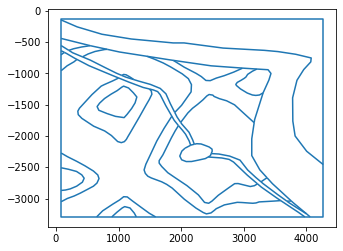

In [55]:
asgpd = gpd.GeoDataFrame(geometry=lines)
asgpd.plot()

In [56]:
asgpd.to_file("data.gpkg", driver="GPKG", layer="lines")